# Deterministic AutoEncoder

## Overview

This code implements a deep learning pipeline that maps brushstroke images to corresponding robotic motion trajectories (in XYZ coordinates).
It combines computer vision (image encoding using DINO) and sequence modeling (motion prediction using LSTMs) in a single framework.

## Import Libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

import numpy as np
import pandas as pd

import glob
from PIL import Image
from tqdm import tqdm


## Dataset

Loads paired data:<br>
.png images (brushstrokes)<br>
.csv files containing corresponding 3D motion data (X_mm, Y_mm, Z_mm)<br>
Normalizes motion data (mm → meters)<br>

Returns:<br>
(image_tensor, motion_sequence, sequence_length)<br>

In [2]:
class BrushStrokeMotionDataset(Dataset):
    def __init__(self, image_dir, motion_dir, transform=None):

        # read and sort the files
        self.image_paths = sorted(glob.glob(image_dir + "*.png"))  
        self.motion_paths = sorted(glob.glob(motion_dir + "*.csv"))

        assert len(self.image_paths) == len(self.motion_paths)

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # read img
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)

        # read motion CSV, only XYZ
        df = pd.read_csv(self.motion_paths[idx])
        #joint = df[['A1','A2','A3','A4','A5','A6','A7']].values.astype(float)
        motion = df[['X_mm','Y_mm','Z_mm']].dropna().values.astype(float)
        motion = motion /1000 # change from mm to m  
        length = motion.shape[0]
        return img, motion, length

def collate_fn(batch):
    imgs, motions, lengths = zip(*batch)
    imgs = torch.stack([transforms.ToTensor()(i) if not isinstance(i, torch.Tensor) else i for i in imgs])
    lengths = torch.tensor(lengths)
    max_len = max(lengths)
    padded_motions = torch.zeros(len(motions), max_len, 3)
    for i, m in enumerate(motions):
        padded_motions[i,:m.shape[0],:] = torch.tensor(m)
    return imgs, padded_motions, lengths

# transform
transform = transforms.Compose([
    transforms.Resize((224,224)),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor()
])

## Model

1. ImageEncoder: <br>
Uses a pretrained DINOv2 ViT-S/14 to extract latent features from input images. <br>
Output → a latent vector representing the brushstroke.

2. MotionDecoder: <br>
Uses an LSTM to generate sequential 3D motion coordinates from the latent vector. <br>
Supports teacher forcing during training.

In [3]:
class ImageEncoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.dino = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
        self.dino.eval()
        for p in self.dino.parameters():
            p.requires_grad = False
        self.latent_fc = nn.Linear(384, latent_dim)  # ViT-Small CLS token dim = 384

    def forward(self, x):
        # x: [B,3,H,W], assume normalized to DINO preprocessing
        with torch.no_grad():
            output = self.dino(x)  # [B,384] CLS token
        latent = self.latent_fc(output)  # [B, latent_dim]
        return latent
    

class MotionDecoder(nn.Module):
    def __init__(self, latent_dim=512, hidden_dim=512, num_joints=3, num_layers=2):
        super().__init__()
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_dim)
        self.lstm = nn.LSTM(input_size=num_joints, hidden_size=hidden_dim,
                            num_layers=num_layers, batch_first=True)
        self.output_fc = nn.Linear(hidden_dim, num_joints)
    
    def forward(self, latent, motion_seq=None, teacher_forcing_ratio=0.5):
        B = latent.size(0)
        device = latent.device
        hidden = torch.tanh(self.latent_to_hidden(latent)).unsqueeze(0).repeat(self.lstm.num_layers,1,1)
        cell = torch.zeros_like(hidden)
        
        outputs = []
        input_t = torch.zeros(B,3).to(device)
        T = motion_seq.size(1) if motion_seq is not None else 75  
        
        for t in range(T):
            out, (hidden, cell) = self.lstm(input_t.unsqueeze(1), (hidden,cell))
            out = self.output_fc(out.squeeze(1))
            outputs.append(out.unsqueeze(1))
            if motion_seq is not None and torch.rand(1).item() < teacher_forcing_ratio:
                input_t = motion_seq[:,t,:]
            else:
                input_t = out
        outputs = torch.cat(outputs,dim=1)
        return outputs

class Image2Motion(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = ImageEncoder(latent_dim)
        self.decoder = MotionDecoder(latent_dim)
    
    def forward(self, images, motion_seq=None, teacher_forcing_ratio=0.5):
        latent = self.encoder(images)
        outputs = self.decoder(latent, motion_seq, teacher_forcing_ratio)
        return outputs, latent

## Config


In [5]:
config = {
    "batch_size": 128,
    "latent_dim": 512,
    "lr": 1e-4,
    "num_epochs": 200,
    "train_val_split": 0.8
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Image2Motion(config["latent_dim"]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss(reduction='none')


dataset = BrushStrokeMotionDataset(
    image_dir="dataset generation/data_img_5000(parametric)/",
    motion_dir="dataset generation/data_motion_5000(parametric)/",
    transform=transform
)

train_size = int(len(dataset) * config["train_val_split"])
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
patience = 40


train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False, collate_fn=collate_fn)
save_path = "image2motion_best.pth"


Using cache found in C:\Users\ellen/.cache\torch\hub\facebookresearch_dinov2_main


## Loss Function

In [6]:
def motion_loss(outputs, motions, lengths, criterion, smooth_weight=0.1, normalize=True):
    """
    outputs, motions: [B, T, 3] (X, Y, Z in mm)
    lengths: [B] sequence lengths
    criterion: e.g., nn.MSELoss(reduction='none')
    smooth_weight: weight for smoothness loss
    normalize: if True, scale each dimension to [-1,1] using predefined min/max
    """
    device = outputs.device
    max_len = motions.size(1)
    mask = (torch.arange(max_len, device=device).unsqueeze(0) < lengths.unsqueeze(1)).float()  # [B, T]

    # Per-dim normalization
    if normalize:
        #  X/Y/Z min/max
        min_vals = torch.tensor([12.0/1000, -660.0/1000, 0.0], device=device)   # X,Y,Z min
        max_vals = torch.tensor([92.0/1000, -570.0/1000, 10.0/1000], device=device) # X,Y,Z max

        motions_norm = 2 * (motions - min_vals) / (max_vals - min_vals) - 1
        outputs_norm = 2 * (outputs - min_vals) / (max_vals - min_vals) - 1
    else:
        motions_norm = motions
        outputs_norm = outputs

    # MSE loss
    mse_loss = (criterion(outputs_norm, motions_norm).sum(-1) * mask).sum() / mask.sum()

    # Smoothness loss
    delta_pred = outputs_norm[:, 1:, :] - outputs_norm[:, :-1, :]
    delta_true = motions_norm[:, 1:, :] - motions_norm[:, :-1, :]
    mask_smooth = mask[:, 1:]
    smooth_loss = (criterion(delta_pred, delta_true).sum(-1) * mask_smooth).sum() / mask_smooth.sum()

    # Total loss
    total_loss = mse_loss + smooth_weight * smooth_loss
    return total_loss, mse_loss.item(), smooth_loss.item()

## Main Train Loop

In [ ]:
train_losses, val_losses = [], []
best_val_loss = float('inf')
no_improve_epochs = 0       
               
for epoch in range(config["num_epochs"]):
    # ---- train ----
    model.train()
    epoch_train_loss = 0.0
    for images, motions, lengths in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']} [Train]"):
        images, motions, lengths = images.to(device), motions.to(device), lengths.to(device)
        outputs, latent = model(images, motions, teacher_forcing_ratio=0.5)

        loss, mse_loss_val, smooth_loss_val = motion_loss(outputs, motions, lengths, criterion)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * images.size(0)

    epoch_train_loss /= len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # ---- validation ----
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for images, motions, lengths in tqdm(val_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']} [Val]"):
            images, motions, lengths = images.to(device), motions.to(device), lengths.to(device)
            outputs, latent = model(images, motions, teacher_forcing_ratio=0.0)

            loss, mse_loss_val, smooth_loss_val = motion_loss(outputs, motions, lengths, criterion)
            epoch_val_loss += loss.item() * images.size(0)

        epoch_val_loss /= len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

    # save last epoch for checkpoint
    torch.save(model.state_dict(), "image2motion_last.pth")

    # save best model & early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), "image2motion_best.pth")
        no_improve_epochs = 0  # reset counter
        print(f"Epoch {epoch+1}/{config['num_epochs']}: "
              f"Train Loss={epoch_train_loss:.4f}, Val Loss={epoch_val_loss:.4f} --> best model saved")
    else:
        no_improve_epochs += 1
        print(f"Epoch {epoch+1}/{config['num_epochs']}: "
              f"Train Loss={epoch_train_loss:.4f}, Val Loss={epoch_val_loss:.4f} "
              f"(no improvement {no_improve_epochs}/{patience})")

    # trigger early stopping
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break



Epoch 1/200 [Val]: 100%|██████████| 8/8 [00:11<00:00,  1.46s/it]


Epoch 1/200: Train Loss=84.2947, Val Loss=3.9528 --> best model saved


Epoch 2/200 [Val]: 100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


Epoch 2/200: Train Loss=1.7900, Val Loss=0.5605 --> best model saved


Epoch 3/200 [Val]: 100%|██████████| 8/8 [00:13<00:00,  1.67s/it]


Epoch 3/200: Train Loss=0.3655, Val Loss=0.3059 --> best model saved


Epoch 4/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.76s/it]


Epoch 4/200: Train Loss=0.2941, Val Loss=0.2927 --> best model saved


Epoch 5/200 [Val]: 100%|██████████| 8/8 [00:15<00:00,  1.92s/it]


Epoch 5/200: Train Loss=0.2862, Val Loss=0.2882 --> best model saved


Epoch 6/200 [Val]: 100%|██████████| 8/8 [00:15<00:00,  1.89s/it]


Epoch 6/200: Train Loss=0.2827, Val Loss=0.2854 --> best model saved


Epoch 7/200 [Val]: 100%|██████████| 8/8 [00:13<00:00,  1.74s/it]


Epoch 7/200: Train Loss=0.2831, Val Loss=0.2836 --> best model saved


Epoch 8/200 [Val]: 100%|██████████| 8/8 [00:16<00:00,  2.03s/it]


Epoch 8/200: Train Loss=0.2849, Val Loss=0.2792 --> best model saved


Epoch 9/200 [Val]: 100%|██████████| 8/8 [00:13<00:00,  1.75s/it]


Epoch 9/200: Train Loss=0.2838, Val Loss=0.2883 (no improvement 1/40)


Epoch 10/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.77s/it]


Epoch 10/200: Train Loss=0.2938, Val Loss=0.2797 (no improvement 2/40)


Epoch 11/200 [Val]: 100%|██████████| 8/8 [00:13<00:00,  1.72s/it]


Epoch 11/200: Train Loss=0.2867, Val Loss=0.2891 (no improvement 3/40)


Epoch 12/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.76s/it]


Epoch 12/200: Train Loss=0.2842, Val Loss=0.2746 --> best model saved


Epoch 13/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.75s/it]


Epoch 13/200: Train Loss=0.2738, Val Loss=0.2775 (no improvement 1/40)


Epoch 14/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.77s/it]


Epoch 14/200: Train Loss=0.2739, Val Loss=0.2738 --> best model saved


Epoch 15/200 [Val]: 100%|██████████| 8/8 [00:13<00:00,  1.72s/it]


Epoch 15/200: Train Loss=0.3840, Val Loss=0.2735 --> best model saved


Epoch 16/200 [Val]: 100%|██████████| 8/8 [00:13<00:00,  1.74s/it]


Epoch 16/200: Train Loss=0.2727, Val Loss=0.2725 --> best model saved


Epoch 17/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.76s/it]


Epoch 17/200: Train Loss=0.2696, Val Loss=0.2841 (no improvement 1/40)


Epoch 18/200 [Val]: 100%|██████████| 8/8 [00:13<00:00,  1.69s/it]


Epoch 18/200: Train Loss=0.2658, Val Loss=0.2728 (no improvement 2/40)


Epoch 19/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.80s/it]


Epoch 19/200: Train Loss=0.2850, Val Loss=0.2824 (no improvement 3/40)


Epoch 20/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.82s/it]


Epoch 20/200: Train Loss=0.2702, Val Loss=0.2712 --> best model saved


Epoch 21/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.80s/it]


Epoch 21/200: Train Loss=0.2824, Val Loss=0.2684 --> best model saved


Epoch 22/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.82s/it]


Epoch 22/200: Train Loss=0.3014, Val Loss=0.3205 (no improvement 1/40)


Epoch 23/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.80s/it]


Epoch 23/200: Train Loss=0.2830, Val Loss=0.2735 (no improvement 2/40)


Epoch 24/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.80s/it]


Epoch 24/200: Train Loss=0.2670, Val Loss=0.2709 (no improvement 3/40)


Epoch 25/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.80s/it]


Epoch 25/200: Train Loss=0.2725, Val Loss=0.2864 (no improvement 4/40)


Epoch 26/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.80s/it]


Epoch 26/200: Train Loss=0.2627, Val Loss=0.2727 (no improvement 5/40)


Epoch 27/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.83s/it]


Epoch 27/200: Train Loss=0.2916, Val Loss=0.2699 (no improvement 6/40)


Epoch 28/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.84s/it]


Epoch 28/200: Train Loss=0.2737, Val Loss=0.2650 --> best model saved


Epoch 29/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.85s/it]


Epoch 29/200: Train Loss=0.2853, Val Loss=0.3232 (no improvement 1/40)


Epoch 30/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.80s/it]


Epoch 30/200: Train Loss=0.2826, Val Loss=0.2643 --> best model saved


Epoch 31/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.79s/it]


Epoch 31/200: Train Loss=0.2687, Val Loss=0.3607 (no improvement 1/40)


Epoch 32/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.81s/it]


Epoch 32/200: Train Loss=0.2799, Val Loss=0.2822 (no improvement 2/40)


Epoch 33/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.83s/it]


Epoch 33/200: Train Loss=0.2742, Val Loss=0.2622 --> best model saved


Epoch 34/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.83s/it]


Epoch 34/200: Train Loss=0.2657, Val Loss=0.2707 (no improvement 1/40)


Epoch 35/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.84s/it]


Epoch 35/200: Train Loss=0.2770, Val Loss=0.2728 (no improvement 2/40)


Epoch 36/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.82s/it]


Epoch 36/200: Train Loss=0.2677, Val Loss=0.3607 (no improvement 3/40)


Epoch 37/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.79s/it]


Epoch 37/200: Train Loss=0.2723, Val Loss=0.2693 (no improvement 4/40)


Epoch 38/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.83s/it]


Epoch 38/200: Train Loss=0.2646, Val Loss=0.2698 (no improvement 5/40)


Epoch 39/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.83s/it]


Epoch 39/200: Train Loss=0.2583, Val Loss=0.2589 --> best model saved


Epoch 40/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.79s/it]


Epoch 40/200: Train Loss=0.2764, Val Loss=0.2971 (no improvement 1/40)


Epoch 41/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.85s/it]


Epoch 41/200: Train Loss=0.2609, Val Loss=0.2815 (no improvement 2/40)


Epoch 42/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.87s/it]


Epoch 42/200: Train Loss=0.2604, Val Loss=0.2894 (no improvement 3/40)


Epoch 43/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.81s/it]


Epoch 43/200: Train Loss=0.2701, Val Loss=0.3258 (no improvement 4/40)


Epoch 44/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.79s/it]


Epoch 44/200: Train Loss=0.2553, Val Loss=0.2641 (no improvement 5/40)


Epoch 45/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.81s/it]


Epoch 45/200: Train Loss=0.2483, Val Loss=0.2577 --> best model saved


Epoch 46/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.82s/it]


Epoch 46/200: Train Loss=0.2600, Val Loss=0.2647 (no improvement 1/40)


Epoch 47/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.81s/it]


Epoch 47/200: Train Loss=0.2476, Val Loss=0.2547 --> best model saved


Epoch 48/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.83s/it]


Epoch 48/200: Train Loss=0.2617, Val Loss=0.2506 --> best model saved


Epoch 49/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.81s/it]


Epoch 49/200: Train Loss=0.2419, Val Loss=0.2839 (no improvement 1/40)


Epoch 50/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.86s/it]


Epoch 50/200: Train Loss=0.2492, Val Loss=0.2578 (no improvement 2/40)


Epoch 51/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.80s/it]


Epoch 51/200: Train Loss=0.2846, Val Loss=0.2547 (no improvement 3/40)


Epoch 52/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.84s/it]


Epoch 52/200: Train Loss=0.2657, Val Loss=0.2509 (no improvement 4/40)


Epoch 53/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.82s/it]


Epoch 53/200: Train Loss=0.2378, Val Loss=0.2670 (no improvement 5/40)


Epoch 54/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.80s/it]


Epoch 54/200: Train Loss=0.2491, Val Loss=0.2516 (no improvement 6/40)


Epoch 55/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.82s/it]


Epoch 55/200: Train Loss=0.2295, Val Loss=0.2539 (no improvement 7/40)


Epoch 56/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.82s/it]


Epoch 56/200: Train Loss=0.2306, Val Loss=0.2737 (no improvement 8/40)


Epoch 57/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.83s/it]


Epoch 57/200: Train Loss=0.2356, Val Loss=0.2499 --> best model saved


Epoch 58/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.82s/it]


Epoch 58/200: Train Loss=0.2602, Val Loss=0.2942 (no improvement 1/40)


Epoch 59/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.82s/it]


Epoch 59/200: Train Loss=0.2345, Val Loss=0.2680 (no improvement 2/40)


Epoch 60/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.84s/it]


Epoch 60/200: Train Loss=0.2204, Val Loss=0.2566 (no improvement 3/40)


Epoch 61/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.82s/it]


Epoch 61/200: Train Loss=0.2272, Val Loss=0.2496 --> best model saved


Epoch 62/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.81s/it]


Epoch 62/200: Train Loss=0.2212, Val Loss=0.2629 (no improvement 1/40)


Epoch 63/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.84s/it]


Epoch 63/200: Train Loss=0.2520, Val Loss=0.2595 (no improvement 2/40)


Epoch 64/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.83s/it]


Epoch 64/200: Train Loss=0.2114, Val Loss=0.2615 (no improvement 3/40)


Epoch 65/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.80s/it]


Epoch 65/200: Train Loss=0.2105, Val Loss=0.2544 (no improvement 4/40)


Epoch 66/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.85s/it]


Epoch 66/200: Train Loss=0.2121, Val Loss=0.2651 (no improvement 5/40)


Epoch 67/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.80s/it]


Epoch 67/200: Train Loss=0.2237, Val Loss=0.2774 (no improvement 6/40)


Epoch 68/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.76s/it]


Epoch 68/200: Train Loss=0.2253, Val Loss=0.2989 (no improvement 7/40)


Epoch 69/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.83s/it]


Epoch 69/200: Train Loss=0.2011, Val Loss=0.3042 (no improvement 8/40)


Epoch 70/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.80s/it]


Epoch 70/200: Train Loss=0.1876, Val Loss=0.2973 (no improvement 9/40)


Epoch 71/200 [Val]: 100%|██████████| 8/8 [00:16<00:00,  2.05s/it]


Epoch 71/200: Train Loss=0.1838, Val Loss=0.2905 (no improvement 10/40)


Epoch 72/200 [Val]: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it]


Epoch 72/200: Train Loss=0.1931, Val Loss=0.3048 (no improvement 11/40)


Epoch 73/200 [Val]: 100%|██████████| 8/8 [00:16<00:00,  2.06s/it]


Epoch 73/200: Train Loss=0.1782, Val Loss=0.2914 (no improvement 12/40)


Epoch 74/200 [Val]: 100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch 74/200: Train Loss=0.1906, Val Loss=0.2835 (no improvement 13/40)


Epoch 75/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.86s/it]


Epoch 75/200: Train Loss=0.2018, Val Loss=0.3640 (no improvement 14/40)


Epoch 76/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.87s/it]


Epoch 76/200: Train Loss=0.2120, Val Loss=0.2572 (no improvement 15/40)


Epoch 77/200 [Val]: 100%|██████████| 8/8 [00:15<00:00,  1.92s/it]


Epoch 77/200: Train Loss=0.1757, Val Loss=0.3281 (no improvement 16/40)


Epoch 78/200 [Val]: 100%|██████████| 8/8 [00:15<00:00,  1.89s/it]


Epoch 78/200: Train Loss=0.1802, Val Loss=0.2879 (no improvement 17/40)


Epoch 79/200 [Val]: 100%|██████████| 8/8 [00:15<00:00,  1.88s/it]


Epoch 79/200: Train Loss=0.1592, Val Loss=0.3159 (no improvement 18/40)


Epoch 80/200 [Val]: 100%|██████████| 8/8 [00:16<00:00,  2.04s/it]


Epoch 80/200: Train Loss=0.1565, Val Loss=0.2721 (no improvement 19/40)


Epoch 81/200 [Val]: 100%|██████████| 8/8 [00:16<00:00,  2.01s/it]


Epoch 81/200: Train Loss=0.1527, Val Loss=0.3382 (no improvement 20/40)


Epoch 82/200 [Val]: 100%|██████████| 8/8 [00:13<00:00,  1.64s/it]


Epoch 82/200: Train Loss=0.1760, Val Loss=0.3306 (no improvement 21/40)


Epoch 83/200 [Val]: 100%|██████████| 8/8 [00:20<00:00,  2.61s/it]


Epoch 83/200: Train Loss=0.1538, Val Loss=0.3777 (no improvement 22/40)


Epoch 84/200 [Val]: 100%|██████████| 8/8 [00:18<00:00,  2.32s/it]


Epoch 84/200: Train Loss=0.1603, Val Loss=1.4787 (no improvement 23/40)


Epoch 85/200 [Val]: 100%|██████████| 8/8 [00:20<00:00,  2.52s/it]


Epoch 85/200: Train Loss=0.1934, Val Loss=0.2876 (no improvement 24/40)


Epoch 86/200 [Val]: 100%|██████████| 8/8 [00:16<00:00,  2.07s/it]


Epoch 86/200: Train Loss=0.1367, Val Loss=0.2968 (no improvement 25/40)


Epoch 87/200 [Val]: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


Epoch 87/200: Train Loss=0.1332, Val Loss=0.2740 (no improvement 26/40)


Epoch 88/200 [Val]: 100%|██████████| 8/8 [00:16<00:00,  2.01s/it]


Epoch 88/200: Train Loss=0.1423, Val Loss=0.6095 (no improvement 27/40)


Epoch 89/200 [Val]: 100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


Epoch 89/200: Train Loss=0.1257, Val Loss=0.2729 (no improvement 28/40)


Epoch 90/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.84s/it]


Epoch 90/200: Train Loss=0.1494, Val Loss=0.6035 (no improvement 29/40)


Epoch 91/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.79s/it]


Epoch 91/200: Train Loss=0.1285, Val Loss=0.2704 (no improvement 30/40)


Epoch 92/200 [Val]: 100%|██████████| 8/8 [00:15<00:00,  1.89s/it]


Epoch 92/200: Train Loss=0.1287, Val Loss=0.3889 (no improvement 31/40)


Epoch 93/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.82s/it]


Epoch 93/200: Train Loss=0.1153, Val Loss=0.3674 (no improvement 32/40)


Epoch 94/200 [Val]: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


Epoch 94/200: Train Loss=0.1551, Val Loss=0.3196 (no improvement 33/40)


Epoch 95/200 [Val]: 100%|██████████| 8/8 [00:20<00:00,  2.51s/it]


Epoch 95/200: Train Loss=0.1440, Val Loss=0.3615 (no improvement 34/40)


Epoch 96/200 [Val]: 100%|██████████| 8/8 [00:13<00:00,  1.70s/it]


Epoch 96/200: Train Loss=0.1374, Val Loss=0.4346 (no improvement 35/40)


Epoch 97/200 [Val]: 100%|██████████| 8/8 [00:16<00:00,  2.02s/it]


Epoch 97/200: Train Loss=0.1246, Val Loss=0.2704 (no improvement 36/40)


Epoch 98/200 [Val]: 100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 98/200: Train Loss=0.1109, Val Loss=0.2446 --> best model saved


Epoch 99/200 [Val]: 100%|██████████| 8/8 [00:18<00:00,  2.31s/it]


Epoch 99/200: Train Loss=0.1128, Val Loss=0.2600 (no improvement 1/40)


Epoch 100/200 [Val]: 100%|██████████| 8/8 [00:21<00:00,  2.68s/it]


Epoch 100/200: Train Loss=0.1152, Val Loss=0.4335 (no improvement 2/40)


Epoch 101/200 [Val]: 100%|██████████| 8/8 [00:21<00:00,  2.65s/it]


Epoch 101/200: Train Loss=0.1286, Val Loss=1.6663 (no improvement 3/40)


Epoch 102/200 [Val]: 100%|██████████| 8/8 [00:15<00:00,  1.88s/it]


Epoch 102/200: Train Loss=0.1996, Val Loss=0.5182 (no improvement 4/40)


Epoch 103/200 [Val]: 100%|██████████| 8/8 [00:13<00:00,  1.73s/it]


Epoch 103/200: Train Loss=0.1170, Val Loss=0.2525 (no improvement 5/40)


Epoch 104/200 [Val]: 100%|██████████| 8/8 [00:13<00:00,  1.73s/it]


Epoch 104/200: Train Loss=0.1062, Val Loss=0.2385 --> best model saved


Epoch 105/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.78s/it]


Epoch 105/200: Train Loss=0.1104, Val Loss=0.3276 (no improvement 1/40)


Epoch 106/200 [Val]: 100%|██████████| 8/8 [00:40<00:00,  5.05s/it]


Epoch 106/200: Train Loss=0.1108, Val Loss=0.2445 (no improvement 2/40)


Epoch 107/200 [Val]: 100%|██████████| 8/8 [00:12<00:00,  1.61s/it]


Epoch 107/200: Train Loss=0.1031, Val Loss=0.6571 (no improvement 3/40)


Epoch 108/200 [Val]: 100%|██████████| 8/8 [00:16<00:00,  2.01s/it]


Epoch 108/200: Train Loss=0.1713, Val Loss=0.3197 (no improvement 4/40)


Epoch 109/200 [Val]: 100%|██████████| 8/8 [00:15<00:00,  1.92s/it]


Epoch 109/200: Train Loss=0.1071, Val Loss=0.2994 (no improvement 5/40)


Epoch 110/200 [Val]: 100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 110/200: Train Loss=0.1257, Val Loss=1.2028 (no improvement 6/40)


Epoch 111/200 [Val]: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it]


Epoch 111/200: Train Loss=0.1219, Val Loss=0.3325 (no improvement 7/40)


Epoch 112/200 [Val]: 100%|██████████| 8/8 [00:22<00:00,  2.83s/it]


Epoch 112/200: Train Loss=0.1089, Val Loss=0.3380 (no improvement 8/40)


Epoch 113/200 [Val]: 100%|██████████| 8/8 [00:20<00:00,  2.55s/it]


Epoch 113/200: Train Loss=0.1246, Val Loss=0.2495 (no improvement 9/40)


Epoch 114/200 [Val]: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


Epoch 114/200: Train Loss=0.1024, Val Loss=0.2806 (no improvement 10/40)


Epoch 115/200 [Val]: 100%|██████████| 8/8 [00:21<00:00,  2.73s/it]


Epoch 115/200: Train Loss=0.1145, Val Loss=0.4211 (no improvement 11/40)


Epoch 116/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.85s/it]


Epoch 116/200: Train Loss=0.1864, Val Loss=0.2916 (no improvement 12/40)


Epoch 117/200 [Val]: 100%|██████████| 8/8 [00:22<00:00,  2.80s/it]


Epoch 117/200: Train Loss=0.1030, Val Loss=0.3089 (no improvement 13/40)


Epoch 118/200 [Val]: 100%|██████████| 8/8 [00:18<00:00,  2.25s/it]


Epoch 118/200: Train Loss=0.0865, Val Loss=0.2870 (no improvement 14/40)


Epoch 119/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.77s/it]


Epoch 119/200: Train Loss=0.0851, Val Loss=0.2890 (no improvement 15/40)


Epoch 120/200 [Val]: 100%|██████████| 8/8 [00:16<00:00,  2.12s/it]


Epoch 120/200: Train Loss=0.0956, Val Loss=0.3601 (no improvement 16/40)


Epoch 121/200 [Val]: 100%|██████████| 8/8 [00:18<00:00,  2.31s/it]


Epoch 121/200: Train Loss=0.1052, Val Loss=0.3999 (no improvement 17/40)


Epoch 122/200 [Val]: 100%|██████████| 8/8 [00:17<00:00,  2.14s/it]


Epoch 122/200: Train Loss=0.1183, Val Loss=0.3584 (no improvement 18/40)


Epoch 123/200 [Val]: 100%|██████████| 8/8 [00:14<00:00,  1.79s/it]


Epoch 123/200: Train Loss=0.0860, Val Loss=0.6457 (no improvement 19/40)


Epoch 124/200 [Val]: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it]


Epoch 124/200: Train Loss=0.0904, Val Loss=0.3061 (no improvement 20/40)


Epoch 125/200 [Val]: 100%|██████████| 8/8 [00:22<00:00,  2.84s/it]


Epoch 125/200: Train Loss=0.0775, Val Loss=0.3887 (no improvement 21/40)


Epoch 126/200 [Val]: 100%|██████████| 8/8 [00:26<00:00,  3.34s/it]


Epoch 126/200: Train Loss=0.1759, Val Loss=0.2632 (no improvement 22/40)


Epoch 127/200 [Val]: 100%|██████████| 8/8 [00:25<00:00,  3.21s/it]


Epoch 127/200: Train Loss=0.0741, Val Loss=0.2696 (no improvement 23/40)


Epoch 128/200 [Val]: 100%|██████████| 8/8 [00:26<00:00,  3.28s/it]


Epoch 128/200: Train Loss=0.0733, Val Loss=0.4396 (no improvement 24/40)


Epoch 129/200 [Val]: 100%|██████████| 8/8 [00:26<00:00,  3.26s/it]


Epoch 129/200: Train Loss=0.0991, Val Loss=0.2799 (no improvement 25/40)


Epoch 130/200 [Val]: 100%|██████████| 8/8 [00:25<00:00,  3.22s/it]


Epoch 130/200: Train Loss=0.0958, Val Loss=0.3609 (no improvement 26/40)


Epoch 131/200 [Val]: 100%|██████████| 8/8 [00:25<00:00,  3.13s/it]


Epoch 131/200: Train Loss=0.0801, Val Loss=0.3588 (no improvement 27/40)


Epoch 132/200 [Val]: 100%|██████████| 8/8 [00:19<00:00,  2.47s/it]


Epoch 132/200: Train Loss=0.1377, Val Loss=1.2642 (no improvement 28/40)


Epoch 133/200 [Val]: 100%|██████████| 8/8 [00:22<00:00,  2.79s/it]


Epoch 133/200: Train Loss=0.1151, Val Loss=0.2435 (no improvement 29/40)


Epoch 134/200 [Val]: 100%|██████████| 8/8 [00:25<00:00,  3.22s/it]


Epoch 134/200: Train Loss=0.0722, Val Loss=0.3629 (no improvement 30/40)


Epoch 135/200 [Val]: 100%|██████████| 8/8 [00:26<00:00,  3.30s/it]


Epoch 135/200: Train Loss=0.0813, Val Loss=0.6115 (no improvement 31/40)


Epoch 136/200 [Val]: 100%|██████████| 8/8 [00:25<00:00,  3.18s/it]


Epoch 136/200: Train Loss=0.1067, Val Loss=0.3919 (no improvement 32/40)


Epoch 137/200 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.10s/it]


Epoch 137/200: Train Loss=0.0696, Val Loss=0.3178 (no improvement 33/40)


Epoch 138/200 [Val]: 100%|██████████| 8/8 [00:28<00:00,  3.51s/it]


Epoch 138/200: Train Loss=0.0854, Val Loss=0.4810 (no improvement 34/40)


Epoch 139/200 [Val]: 100%|██████████| 8/8 [00:21<00:00,  2.67s/it]


Epoch 139/200: Train Loss=0.0763, Val Loss=0.8069 (no improvement 35/40)


Epoch 140/200 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.01s/it]


Epoch 140/200: Train Loss=0.1245, Val Loss=0.3597 (no improvement 36/40)


Epoch 141/200 [Val]: 100%|██████████| 8/8 [00:25<00:00,  3.16s/it]


Epoch 141/200: Train Loss=0.0673, Val Loss=0.2542 (no improvement 37/40)


Epoch 142/200 [Val]: 100%|██████████| 8/8 [00:20<00:00,  2.53s/it]


Epoch 142/200: Train Loss=0.1029, Val Loss=0.2747 (no improvement 38/40)


Epoch 143/200 [Val]: 100%|██████████| 8/8 [00:19<00:00,  2.39s/it]


Epoch 143/200: Train Loss=0.0944, Val Loss=0.2230 --> best model saved


Epoch 144/200 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.04s/it]


Epoch 144/200: Train Loss=0.0725, Val Loss=0.3161 (no improvement 1/40)


Epoch 145/200 [Val]: 100%|██████████| 8/8 [00:23<00:00,  2.98s/it]


Epoch 145/200: Train Loss=0.0636, Val Loss=0.2341 (no improvement 2/40)


Epoch 146/200 [Val]: 100%|██████████| 8/8 [00:18<00:00,  2.37s/it]


Epoch 146/200: Train Loss=0.0655, Val Loss=0.2500 (no improvement 3/40)


Epoch 147/200 [Val]: 100%|██████████| 8/8 [00:21<00:00,  2.65s/it]


Epoch 147/200: Train Loss=0.0689, Val Loss=0.4255 (no improvement 4/40)


Epoch 148/200 [Val]: 100%|██████████| 8/8 [00:22<00:00,  2.79s/it]


Epoch 148/200: Train Loss=0.2956, Val Loss=0.4341 (no improvement 5/40)


Epoch 149/200 [Val]: 100%|██████████| 8/8 [00:21<00:00,  2.75s/it]


Epoch 149/200: Train Loss=0.1032, Val Loss=1.0990 (no improvement 6/40)


Epoch 150/200 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.11s/it]


Epoch 150/200: Train Loss=0.0790, Val Loss=0.7066 (no improvement 7/40)


Epoch 151/200 [Val]: 100%|██████████| 8/8 [00:26<00:00,  3.34s/it]


Epoch 151/200: Train Loss=0.0649, Val Loss=0.2239 (no improvement 8/40)


Epoch 152/200 [Val]: 100%|██████████| 8/8 [00:22<00:00,  2.84s/it]


Epoch 152/200: Train Loss=0.0569, Val Loss=0.4767 (no improvement 9/40)


Epoch 153/200 [Val]: 100%|██████████| 8/8 [00:23<00:00,  2.92s/it]


Epoch 153/200: Train Loss=0.0633, Val Loss=0.2547 (no improvement 10/40)


Epoch 154/200 [Val]: 100%|██████████| 8/8 [00:25<00:00,  3.20s/it]


Epoch 154/200: Train Loss=0.0550, Val Loss=0.2057 --> best model saved


Epoch 155/200 [Val]: 100%|██████████| 8/8 [00:19<00:00,  2.41s/it]


Epoch 155/200: Train Loss=0.0494, Val Loss=0.3647 (no improvement 1/40)


Epoch 156/200 [Val]: 100%|██████████| 8/8 [00:21<00:00,  2.67s/it]


Epoch 156/200: Train Loss=0.3175, Val Loss=0.6330 (no improvement 2/40)


Epoch 157/200 [Val]: 100%|██████████| 8/8 [00:22<00:00,  2.79s/it]


Epoch 157/200: Train Loss=0.1079, Val Loss=0.2325 (no improvement 3/40)


Epoch 158/200 [Val]: 100%|██████████| 8/8 [00:21<00:00,  2.69s/it]


Epoch 158/200: Train Loss=0.0691, Val Loss=0.3608 (no improvement 4/40)


Epoch 159/200 [Val]: 100%|██████████| 8/8 [00:22<00:00,  2.78s/it]


Epoch 159/200: Train Loss=0.0629, Val Loss=0.2120 (no improvement 5/40)


Epoch 160/200 [Val]: 100%|██████████| 8/8 [00:21<00:00,  2.63s/it]


Epoch 160/200: Train Loss=0.0611, Val Loss=0.4226 (no improvement 6/40)


Epoch 161/200 [Val]: 100%|██████████| 8/8 [00:27<00:00,  3.42s/it]


Epoch 161/200: Train Loss=0.0755, Val Loss=0.3052 (no improvement 7/40)


Epoch 162/200 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.03s/it]


Epoch 162/200: Train Loss=0.0504, Val Loss=0.2246 (no improvement 8/40)


Epoch 163/200 [Val]: 100%|██████████| 8/8 [00:23<00:00,  2.94s/it]


Epoch 163/200: Train Loss=0.0492, Val Loss=0.2277 (no improvement 9/40)


Epoch 164/200 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.07s/it]


Epoch 164/200: Train Loss=0.0512, Val Loss=0.4732 (no improvement 10/40)


Epoch 165/200 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.10s/it]


Epoch 165/200: Train Loss=0.0543, Val Loss=0.2567 (no improvement 11/40)


Epoch 166/200 [Val]: 100%|██████████| 8/8 [00:23<00:00,  2.93s/it]


Epoch 166/200: Train Loss=0.0578, Val Loss=0.4354 (no improvement 12/40)


Epoch 167/200 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.12s/it]


Epoch 167/200: Train Loss=0.0721, Val Loss=0.4219 (no improvement 13/40)


Epoch 168/200 [Val]: 100%|██████████| 8/8 [00:23<00:00,  2.99s/it]


Epoch 168/200: Train Loss=0.0790, Val Loss=0.3519 (no improvement 14/40)


Epoch 169/200 [Val]: 100%|██████████| 8/8 [00:26<00:00,  3.34s/it]


Epoch 169/200: Train Loss=0.0771, Val Loss=0.5305 (no improvement 15/40)


Epoch 170/200 [Val]: 100%|██████████| 8/8 [00:22<00:00,  2.76s/it]


Epoch 170/200: Train Loss=0.0483, Val Loss=0.2840 (no improvement 16/40)


Epoch 171/200 [Val]: 100%|██████████| 8/8 [00:22<00:00,  2.79s/it]


Epoch 171/200: Train Loss=0.0544, Val Loss=0.3280 (no improvement 17/40)


Epoch 172/200 [Val]: 100%|██████████| 8/8 [00:28<00:00,  3.62s/it]


Epoch 172/200: Train Loss=0.1658, Val Loss=0.3152 (no improvement 18/40)


Epoch 173/200 [Val]: 100%|██████████| 8/8 [00:32<00:00,  4.02s/it]


Epoch 173/200: Train Loss=0.1046, Val Loss=0.2880 (no improvement 19/40)


Epoch 174/200 [Val]: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]


Epoch 174/200: Train Loss=0.0504, Val Loss=0.3667 (no improvement 20/40)


Epoch 175/200 [Val]: 100%|██████████| 8/8 [00:28<00:00,  3.51s/it]


Epoch 175/200: Train Loss=0.0442, Val Loss=0.2144 (no improvement 21/40)


Epoch 176/200 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.01s/it]


Epoch 176/200: Train Loss=0.0445, Val Loss=0.2665 (no improvement 22/40)


Epoch 177/200 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.11s/it]


Epoch 177/200: Train Loss=0.0715, Val Loss=1.7561 (no improvement 23/40)


Epoch 178/200 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.06s/it]


Epoch 178/200: Train Loss=0.1341, Val Loss=0.4063 (no improvement 24/40)


Epoch 179/200 [Val]: 100%|██████████| 8/8 [00:25<00:00,  3.13s/it]


Epoch 179/200: Train Loss=0.0473, Val Loss=0.3340 (no improvement 25/40)


Epoch 180/200 [Val]: 100%|██████████| 8/8 [00:25<00:00,  3.20s/it]


Epoch 180/200: Train Loss=0.0448, Val Loss=0.2818 (no improvement 26/40)


Epoch 181/200 [Val]: 100%|██████████| 8/8 [00:25<00:00,  3.23s/it]


Epoch 181/200: Train Loss=0.1090, Val Loss=0.5165 (no improvement 27/40)


Epoch 182/200 [Val]: 100%|██████████| 8/8 [00:25<00:00,  3.13s/it]


Epoch 182/200: Train Loss=0.0747, Val Loss=0.5817 (no improvement 28/40)


Epoch 183/200 [Val]: 100%|██████████| 8/8 [00:25<00:00,  3.14s/it]


Epoch 183/200: Train Loss=0.0574, Val Loss=0.2713 (no improvement 29/40)


Epoch 184/200 [Val]: 100%|██████████| 8/8 [00:25<00:00,  3.15s/it]


Epoch 184/200: Train Loss=0.0462, Val Loss=0.3400 (no improvement 30/40)


Epoch 185/200 [Val]: 100%|██████████| 8/8 [00:26<00:00,  3.37s/it]


Epoch 185/200: Train Loss=0.0396, Val Loss=0.3252 (no improvement 31/40)


Epoch 186/200 [Val]: 100%|██████████| 8/8 [00:25<00:00,  3.13s/it]


Epoch 186/200: Train Loss=0.0519, Val Loss=7.6609 (no improvement 32/40)


Epoch 187/200 [Val]: 100%|██████████| 8/8 [00:25<00:00,  3.18s/it]


Epoch 187/200: Train Loss=0.0907, Val Loss=0.5257 (no improvement 33/40)


Epoch 188/200 [Val]: 100%|██████████| 8/8 [00:23<00:00,  2.90s/it]


Epoch 188/200: Train Loss=0.0439, Val Loss=0.2863 (no improvement 34/40)


Epoch 189/200 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.12s/it]


Epoch 189/200: Train Loss=0.0442, Val Loss=35.8755 (no improvement 35/40)


Epoch 190/200 [Val]: 100%|██████████| 8/8 [00:26<00:00,  3.29s/it]


Epoch 190/200: Train Loss=0.3081, Val Loss=0.5427 (no improvement 36/40)


Epoch 191/200 [Val]: 100%|██████████| 8/8 [00:27<00:00,  3.39s/it]


Epoch 191/200: Train Loss=0.0749, Val Loss=0.4201 (no improvement 37/40)


Epoch 192/200 [Val]: 100%|██████████| 8/8 [00:25<00:00,  3.22s/it]


Epoch 192/200: Train Loss=0.0504, Val Loss=0.2688 (no improvement 38/40)


Epoch 193/200 [Val]: 100%|██████████| 8/8 [00:25<00:00,  3.19s/it]


Epoch 193/200: Train Loss=0.0438, Val Loss=0.1867 --> best model saved


Epoch 194/200 [Val]: 100%|██████████| 8/8 [00:25<00:00,  3.14s/it]


Epoch 194/200: Train Loss=0.0400, Val Loss=0.2357 (no improvement 1/40)


Epoch 195/200 [Val]: 100%|██████████| 8/8 [00:24<00:00,  3.05s/it]


Epoch 195/200: Train Loss=0.0401, Val Loss=0.5529 (no improvement 2/40)


Epoch 196/200 [Val]: 100%|██████████| 8/8 [00:23<00:00,  2.98s/it]


Epoch 196/200: Train Loss=0.0381, Val Loss=0.3266 (no improvement 3/40)


Epoch 197/200 [Val]: 100%|██████████| 8/8 [00:22<00:00,  2.78s/it]


Epoch 197/200: Train Loss=0.0381, Val Loss=0.5686 (no improvement 4/40)


Epoch 198/200 [Val]: 100%|██████████| 8/8 [00:33<00:00,  4.13s/it]


Epoch 198/200: Train Loss=0.0475, Val Loss=0.2067 (no improvement 5/40)


Epoch 199/200 [Val]: 100%|██████████| 8/8 [00:28<00:00,  3.53s/it]


Epoch 199/200: Train Loss=0.0450, Val Loss=0.2233 (no improvement 6/40)


Epoch 200/200 [Val]: 100%|██████████| 8/8 [00:28<00:00,  3.57s/it]

Epoch 200/200: Train Loss=0.0516, Val Loss=0.4864 (no improvement 7/40)


In [7]:
# Load model
model.load_state_dict(torch.load("image2motion_best.pth", map_location=device))

<All keys matched successfully>

## Plot Loss

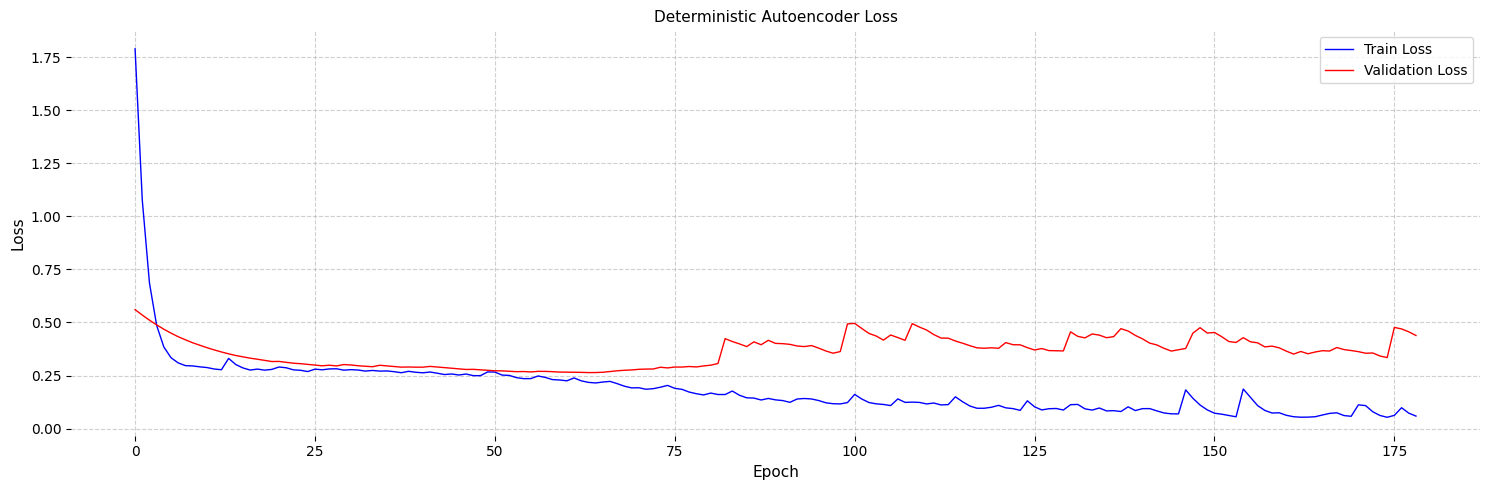

In [ ]:
import re
import matplotlib.pyplot as plt

log_path = "train_log.txt"  # path to your log file
train_losses, val_losses = [], []

with open(log_path, "r", encoding="utf-8") as f:
    for line in f:
        match = re.search(r"Train Loss=([\d.]+), Val Loss=([\d.]+)", line)
        if match:
            train_losses.append(float(match.group(1)))
            val_losses.append(float(match.group(2)))

def smooth_curve(values, smoothing=0.9):
    smoothed = []
    last = values[0]
    for v in values:
        last = last * smoothing + (1 - smoothing) * v
        smoothed.append(last)
    return smoothed

smooth_train = smooth_curve(train_losses[1:180], smoothing=0.5)
smooth_val = smooth_curve(val_losses[1:180], smoothing=0.9)

plt.figure(figsize=(15,5))
plt.plot(smooth_train, 'b-', label='Train Loss', linewidth=1)
plt.plot(smooth_val, 'r-', label='Validation Loss', linewidth=1)
plt.title("Deterministic Autoencoder Loss", fontsize=11)
plt.xlabel("Epoch", fontsize=11)
plt.ylabel("Loss", fontsize=11)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
plt.legend()

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Plot tSNE

Projects learned latent vectors (image embeddings) into 2D for visual inspection. <br>
plot_tsne_brushstroke() → overlays thumbnails of brushstroke images.<br>
plot_tsne_point_density() → shows latent density as a heatmap.<br>

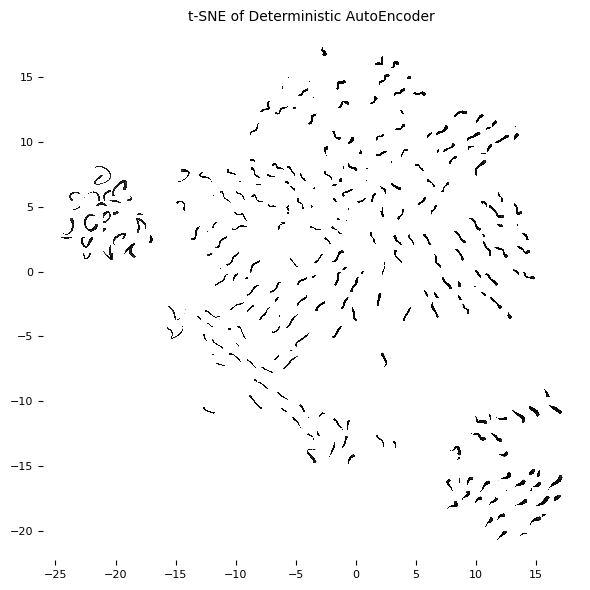

In [ ]:
import matplotlib.offsetbox as offsetbox
from sklearn.manifold import TSNE

def plot_tsne_brushstroke(model, dataset, device='cpu', max_samples=300, random_seed=42):
    """
    Compute latent vectors from the image encoder, then run t-SNE and overlay *original* brushstroke images.
    
    Args:
        model: Image2Motion model
        dataset: BrushStrokeMotionDataset
        device: 'cpu' or 'cuda'
        max_samples: max number of samples to plot
    """
    model.eval()
    np.random.seed(random_seed)

    # randomly sample subset
    idxs = np.random.choice(len(dataset), min(max_samples, len(dataset)), replace=False)
    
    images_list = []
    latents_list = []

    with torch.no_grad():
        for idx in idxs:
            # get original PIL image directly (untransformed)
            orig_img = dataset.get_original_image(idx) if hasattr(dataset, "get_original_image") else dataset.image_paths[idx]
            if isinstance(orig_img, str):
                from PIL import Image
                orig_img = Image.open(orig_img).convert('RGB')

            # for encoding, still need transformed tensor
            img, _, _ = dataset[idx]
            img_tensor = img.unsqueeze(0).to(device)

            # forward encoder to get latent
            latent = model.encoder(img_tensor)
            latents_list.append(latent.cpu().numpy()[0])

            # store *original* image as numpy (unscaled)
            images_list.append(np.array(orig_img))

    latents = np.stack(latents_list)

    # t-SNE
    tsne = TSNE(n_components=2, random_state=random_seed)
    latents_2d = tsne.fit_transform(latents)

    # Plot
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(latents_2d[:,0], latents_2d[:,1], alpha=0)  # invisible points for scaling

    for xy, img in zip(latents_2d, images_list):
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(img, zoom=0.03),
            xy,
            frameon=False
        )
        ax.add_artist(imagebox)
    
    ax.set_title("t-SNE of Deterministic AutoEncoder", fontsize = 10)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(labelsize=8)
    plt.tight_layout()
    plt.show()


plot_tsne_brushstroke(model, dataset, device=device, max_samples=300)

Running t-SNE...


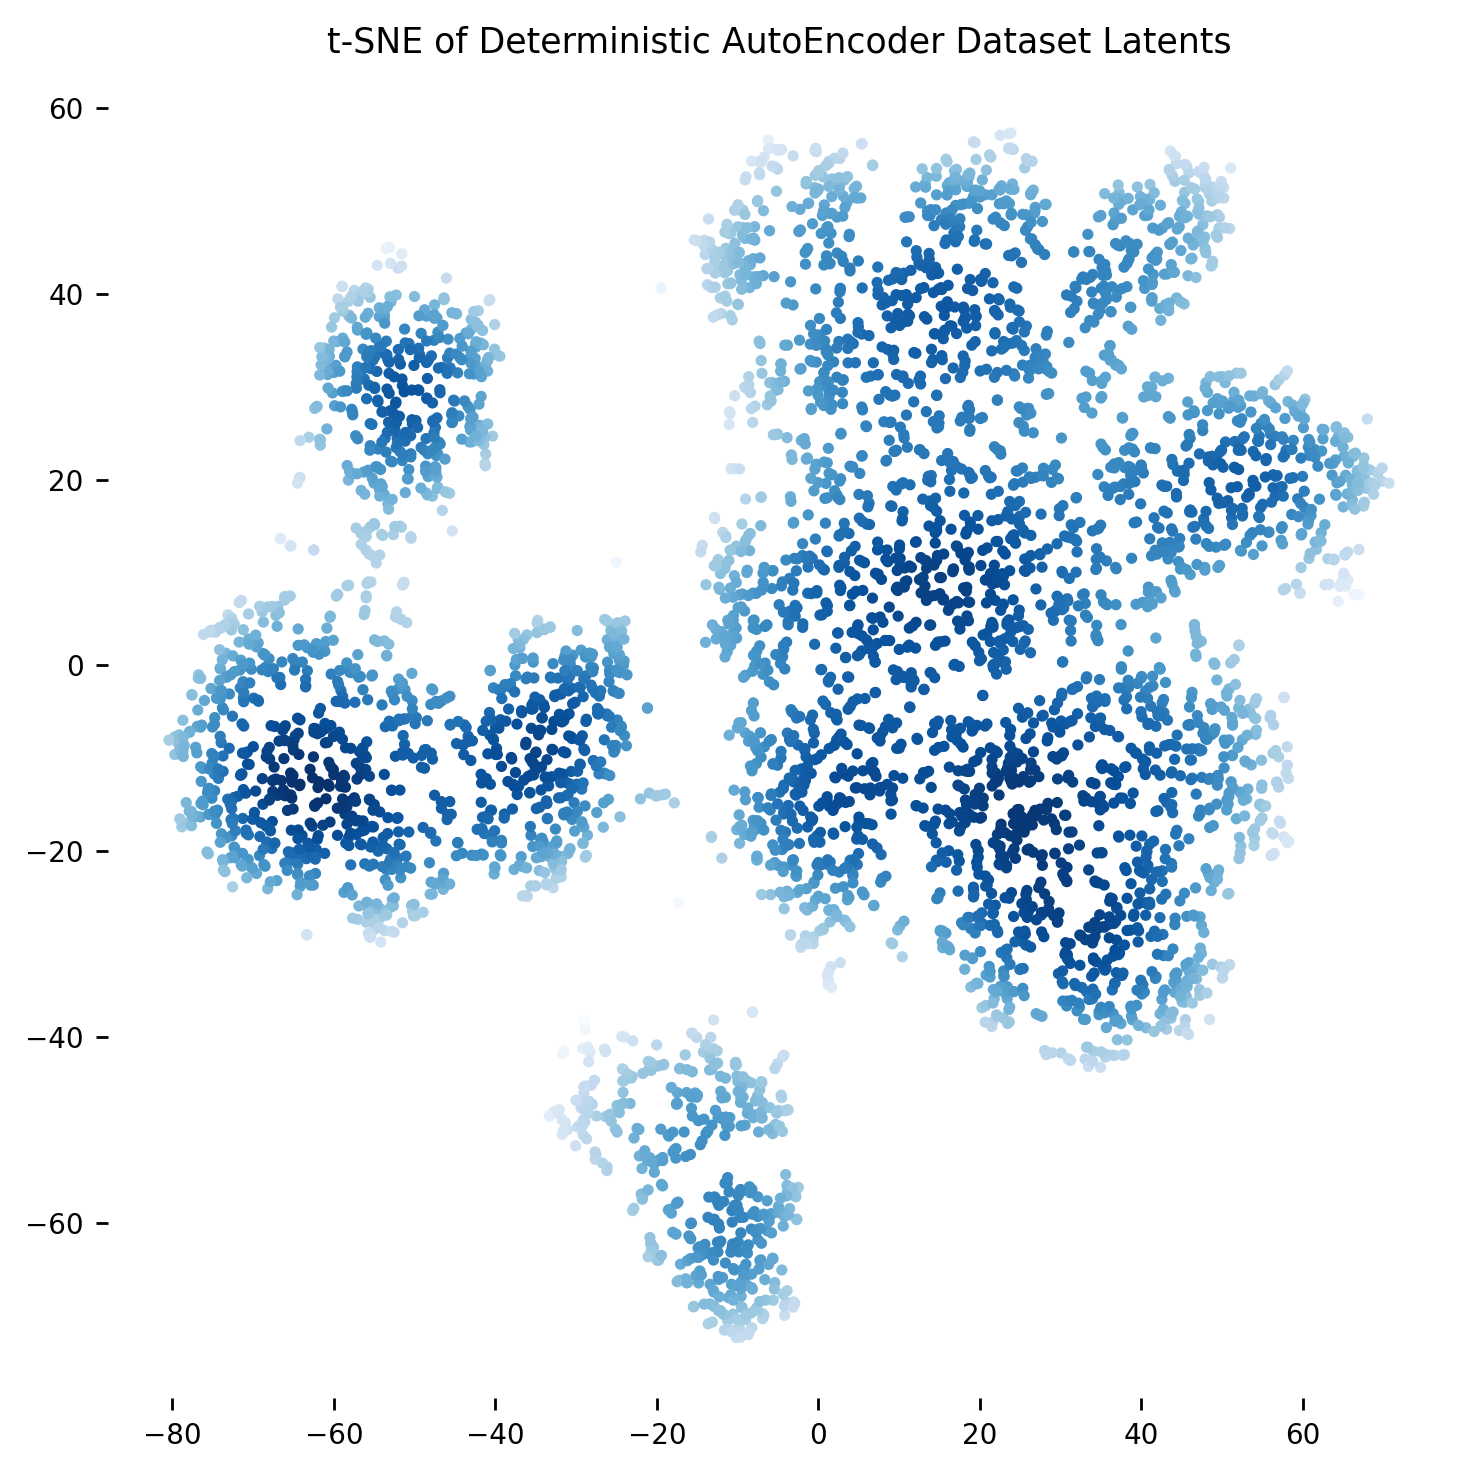

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.stats import gaussian_kde

def plot_tsne_point_density(model, dataset, device='cpu', max_samples=5000, random_seed=42):
    """
    Plot t-SNE where each dataset point is colored by its local density (heatmap scatter).
    """
    model.eval()
    np.random.seed(random_seed)

    # random sample latent
    idxs = np.random.choice(len(dataset), min(max_samples, len(dataset)), replace=False)
    latents = []

    with torch.no_grad():
        for idx in idxs:
            img, _, _ = dataset[idx]
            img_tensor = img.unsqueeze(0).to(device)
            z = model.encoder(img_tensor)
            latents.append(z.cpu().numpy()[0])

    latents = np.stack(latents)

    # t-SNE reduce dimension
    print("Running t-SNE...")
    tsne = TSNE(n_components=2, perplexity=30, random_state=random_seed)
    z_2d = tsne.fit_transform(latents)
    x, y = z_2d[:, 0], z_2d[:, 1]

    # Calculate the density (Gaussian KDE)
    xy = np.vstack([x, y])
    z_density = gaussian_kde(xy)(xy)

    # Draw scatter plot according to the density
    plt.figure(figsize=(6,6), dpi=250)
    scatter = plt.scatter(x, y, c=z_density, s=5, cmap='Blues')

    plt.title("t-SNE of Deterministic AutoEncoder Dataset Latents", fontsize=10)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.tick_params(labelsize=8)
    plt.tight_layout()
    plt.show()

# model.load_state_dict(torch.load("image2motion_best.pth", map_location=device))
plot_tsne_point_density(model, dataset, device=device, max_samples=5000)

## Prediction Evaluation

Compares predicted vs. ground-truth 3D trajectories alongside their input images.

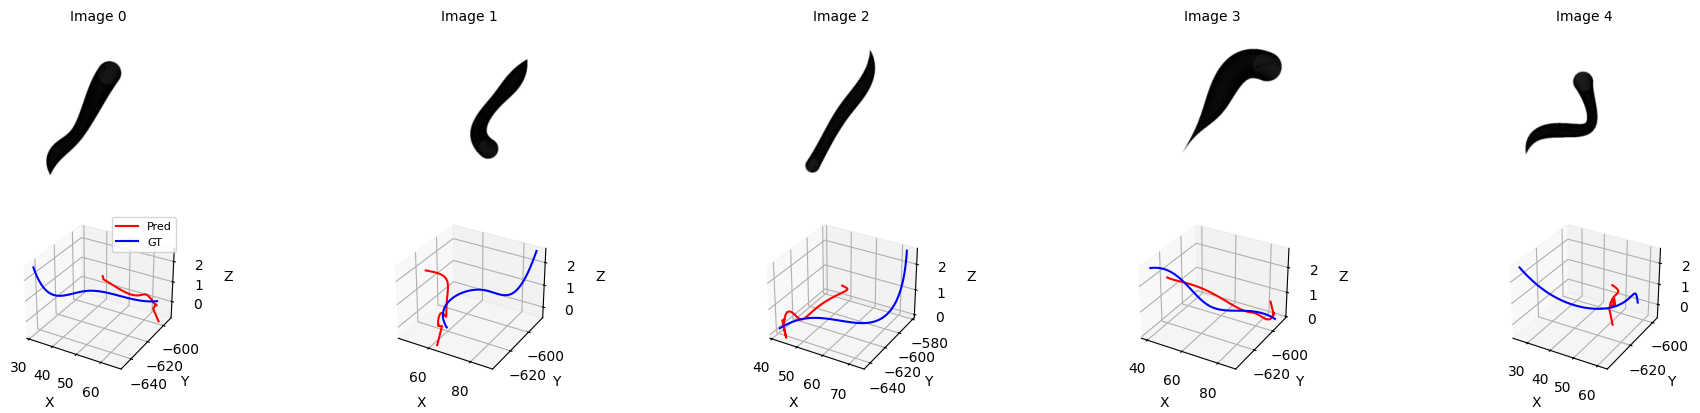

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# save_dir = "csv_outputs_results"
# os.makedirs(save_dir, exist_ok=True)

model.eval()
with torch.no_grad():
    images, motions, lengths = next(iter(train_loader))
    images, motions = images.to(device), motions.to(device)
    outputs, _ = model(images, motion_seq=None, teacher_forcing_ratio=0.0)

    num_samples = min(5, images.size(0))
    fig = plt.figure(figsize=(20,4))
    
    for i in range(num_samples):
        T = lengths[i].item()

        # Convert to numpy back to mm
        pred_xyz = outputs[i, :T, :].cpu().numpy()*1000
        gt_xyz = motions[i, :T, :].cpu().numpy()*1000

        # Save prediction and ground truth to CSV
        # pred_df = pd.DataFrame(pred_xyz, columns=["X_mm", "Y_mm", "Z_mm"])
        # gt_df = pd.DataFrame(gt_xyz, columns=["X_mm", "Y_mm", "Z_mm"])
        # pred_path = os.path.join(save_dir, f"pred_{i}.csv")
        # gt_path = os.path.join(save_dir, f"gt_{i}.csv")
        # pred_df.to_csv(pred_path, index=False)
        # gt_df.to_csv(gt_path, index=False)

        # Upper row: brush stroke image
        ax_img = fig.add_subplot(2, num_samples, i+1)
        img_np = images[i].cpu().permute(1,2,0).numpy()
        ax_img.imshow(img_np)
        ax_img.axis('off')
        ax_img.set_title(f"Image {i}", fontsize=10)
        
        # Lower row: 3D motion plot
        ax_3d = fig.add_subplot(2, num_samples, num_samples + i + 1, projection='3d')
        ax_3d.plot(pred_xyz[:,0], pred_xyz[:,1], pred_xyz[:,2], 'r', label='Pred')
        ax_3d.plot(gt_xyz[:,0], gt_xyz[:,1], gt_xyz[:,2], 'b', label='GT')
        ax_3d.set_xlabel('X'); ax_3d.set_ylabel('Y'); ax_3d.set_zlabel('Z')
        ax_3d.view_init(elev=30, azim=-60)
        if i == 0:
            ax_3d.legend(fontsize=8)

        # print(f"Saved: {pred_path}, {gt_path}")
    
    plt.tight_layout()
    plt.show()